In [2]:
# | default_exp diff_scratch

%load_ext autoreload
%autoreload 2

%env PYDEVD_DISABLE_FILE_VALIDATION=1

env: PYDEVD_DISABLE_FILE_VALIDATION=1


# Diffusion model from scratch

In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import math

# from diffusers import DDPMScheduler, UNet2DModel
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from matplotlib import pyplot as plt
from icecream import ic
import numpy as np
from datetime import datetime
from cop_diffusion.utils import save_model, load_model

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    ]
)
train_dataset = datasets.MNIST(
    root="mnist/", train=True, download=True, transform=transform
)
val_dataset = datasets.MNIST(root="mnist/", train=False, transform=transform)

ic| 'Input shape:', x.shape: torch.Size([8, 1, 28, 28])
ic| 'Labels:', y: tensor([6, 2, 2, 7, 9, 9, 2, 7])


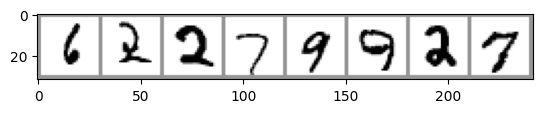

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
oh_y = torch.nn.functional.one_hot(y)
ic("Input shape:", x.shape)
ic("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

## Corruption process

ic| amount.squeeze(): tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])


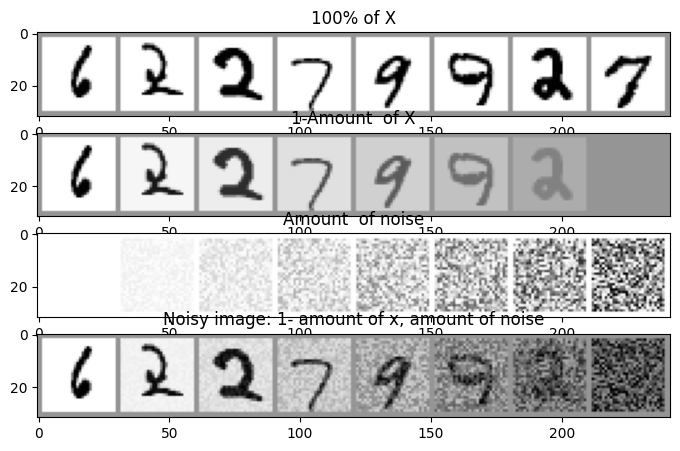

In [6]:
amount = torch.linspace(0, 1, x.shape[0])
amount = amount.view(-1, 1, 1, 1)
mean = 0.0
std = 1.0
noise = torch.rand_like(x) * std + mean
x_noisy = (1 - amount) * x + amount * noise
# x_noisy = amount*noise + x

ic(amount.squeeze())

fig, axs = plt.subplots(4, 1, figsize=(50, 5))
axs[0].set_title("100% of X")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

axs[1].set_title(f"1-Amount  of X")
axs[1].imshow(torchvision.utils.make_grid(x * (1 - amount))[0], cmap="Greys")

axs[2].set_title(f"Amount  of noise")
axs[2].imshow(torchvision.utils.make_grid(noise * amount)[0], cmap="Greys")


axs[3].set_title(f"Noisy image: 1- amount of x, amount of noise")
axs[3].imshow(torchvision.utils.make_grid(x_noisy)[0], cmap="Greys")

### Noise scheduling

- Beta $\beta$, control the noise added at each step. Beta is the noise schedule, the variance of noised added (between 0..1) at each t
- Alpha $\alpha$, control the noise removed at each step $\alpha_t = 1-\beta_t$. This is the **signal retention** 

Choosing the beta schedule is key in the process. It can be
- linear: increase linearly over timestep
- cosine: follow a cosine function, start slowly, increase rapidly, slow down again. Often better perf. 
- quadratic or other non linear schedules. 

#### Forward

Gradually add noise to image over serie of timesteps 
$x_t = \sqrt{\alpha_{\text{cumprod}t}} \cdot x_0 + \sqrt{1 - \alpha_{\text{cumprod}_t}} \cdot \epsilon$

- $\epsilon$ : the gaussian noise
- $x_0$: original image
- $\alpha = 1 - \beta $
- $\alpha_{cumprod_t}$ cumulative product up to time step t. Represent how much of the original image remains after t steps.


#### Reverse diffusion (Denoising)

To reverse diffusion we could do it in 2 different ways:

a. Estimate directly $x_0$ from predicted noise

Estimate what a clean desk would be without the mess. Mentally subtract the mess. So we directly estimate the original image from the noisy one at timestep t. In diffusion model, we don't use it. 
$\hat{x}0 = \frac{x_t - \sqrt{1 - \alpha{\text{cumprod}t}} \cdot \epsilon{\theta}(x_t, t)}{\sqrt{\alpha_{\text{cumprod}_t}}}$

- $\epsilon{\theta}(x_t,t)$: the model prediction of the noise added at timestep t
- $\alpha{\text{cumprod}t}$: how much of the original signal remains. 
 

b. Iterate

Transition to a less messy desk, by using smooth transitions. 
Iteratively remove the noise added in forward process to reconstruct original image from noisy image. Trained model predict the noise.

It incorporate posterior variance randomness that prevent exact reconstruction and avoid collapse. 

$x_{t-1} = \sqrt{\frac{1}{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \alpha_{\text{cumprod}t}}} \cdot \epsilon{\theta}(x_t, t) \right) + \sigma_t \cdot \epsilon$

- $\epsilon$ is some random noise added.
- $\sigma$ is $\frac{1-\alpha_{cumprod_{t-1}}}{1-\alpha_{cumprod_{t}}}{\beta_t}$

##### Why directly estimating $x_0$ isn't used

it would require the model to  handle a wider range of outputs, increasig complexity and variablity. With iterative noise prediction, the output space is consistent and simpler. 

### Cosine schedule
https://www.zainnasir.com/blog/cosine-beta-schedule-for-denoising-diffusion-models/

$\alpha{\text{cumprod}_t}_t = \frac{f(t)}{f(0)}$ where $f(t)=\cos(\frac{\frac{t}{T}+s}{1+s}*\frac{\pi}{2})^2$

Then $\beta_t=1-\frac{\alpha{\text{cumprod}_t}}{\alpha{\text{cumprod}_t} -1}$

The result of the cosine-beta schedule is that it avoids adding too little noise in the beginning and too much noise at the end, while still allowing a considerable increase in the noise in the middle. This ensures that samples at any timestep are equally valuable to the training process.

The cosine-beta schedule also uses a neat little trick using a fixed offset to improve noise prediction in the early timesteps. Having tiny amounts of noise at the beginning makes it hard for the model to predict noise accurately. To avoid this, Nichol and Dhariwal (2021) added an offset 
s=0.008.

ic| x_noisy.shape: torch.Size([8, 1, 28, 28])
    noise.shape: torch.Size([8, 1, 28, 28])


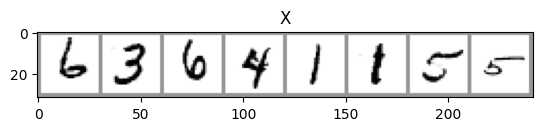

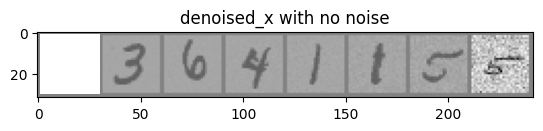

In [7]:
from typing import Literal


class DDPMScheduler(nn.Module):
    def __init__(
        self,
        num_time_steps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 0.02,
        device: str = "cpu",
        type: Literal["linear", "cosine"] = "linear",
    ):
        super().__init__()
        self.num_time_steps = num_time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        if type == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_time_steps, requires_grad=False
            ).to(device)
        elif type == "cosine":
            self.betas = self.cosine_beta_schedule(num_time_steps).to(device)

        self.alphas = 1 - self.betas
        # cumulative product of alphas upto time t, quantiies the amount of info retained at time t in the forward diffusion process
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).requires_grad_(False)
        # special case: t=0, no previous timestep
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0]).to(device), self.alphas_cumprod[:-1]]
        ).requires_grad_(False)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod).to(device)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alphas_cumprod).to(
            device
        )
        self.sqrt_reciprocal_alphas = torch.sqrt(1.0 / self.alphas).to(device)

        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

    def cosine_beta_schedule(
        self, num_timesteps: int, s: float = 0.008
    ) -> torch.Tensor:
        """
        Create a cosine schedule for beta values.
        """
        t = torch.linspace(0, num_timesteps, num_timesteps + 1)
        f = torch.cos(((t / num_timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = f / f[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        return 1 - alphas

    def add_noise_step(self, x, t) -> tuple[torch.Tensor, torch.Tensor]:
        """Gradually add noise to the image"""
        sqrt_alpha_cum_prod_t = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cum_prod_t = self.sqrt_one_minus_alpha_cumprod[t].view(
            -1, 1, 1, 1
        )
        noise = torch.randn_like(x).to(self.device)
        noisy_x = sqrt_alpha_cum_prod_t * x + sqrt_one_minus_alpha_cum_prod_t * noise
        return noisy_x, noise

    def denoise_step(self, pred_noise, x_noisy, t):
        """estimage previous image $x_{t-1}$
        As it incorporate posterior variance, randomnsess that prevent exact reconstruction.
        """
        t = t - 1
        # we get value at time t
        sqrt_reciprocal_alpha_t = self.sqrt_reciprocal_alphas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cum_prod_t = self.sqrt_one_minus_alpha_cumprod[t].view(
            -1, 1, 1, 1
        )
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        posterior_variance_t = self.posterior_variance[t].view(-1, 1, 1, 1)

        # Compute the mean of the posterior q(x_{t-1} | x_t, x_0)
        # Using the DDPM reverse process mean formula
        # pred_mean = sqrt_reciprocal_alpha_t * (x_noisy * beta_t * pred_noise) / sqrt_one_minus_alpha_cum_prod_t
        pred_mean = sqrt_reciprocal_alpha_t * (
            x_noisy - (beta_t / sqrt_one_minus_alpha_cum_prod_t) * pred_noise
        )

        # sample noise for the next step to avoid collaps of model.
        z = torch.randn_like(x_noisy).to(self.device)
        x_prev = pred_mean + torch.sqrt(posterior_variance_t) * z
        return x_prev


scheduler = DDPMScheduler(num_time_steps=500, device=device, type="cosine")
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
t = torch.tensor([0, 50, 100, 150, 200, 300, 400, 499]).to(device)
assert t.shape[0] == x.shape[0], "it should be the same nb of examples"
x = x.to(device)
x_noisy, noise = scheduler.add_noise_step(x, t)
ic(x_noisy.shape, noise.shape)

plt.imshow(torchvision.utils.make_grid(x.cpu())[0], cmap="Greys")
plt.title("X")
plt.show()

# plt.imshow(torchvision.utils.make_grid(x_noisy.cpu())[0], cmap="Greys")
# plt.title("X (noisy)")
# plt.show()

# plt.imshow(torchvision.utils.make_grid(noise.cpu())[0], cmap="Greys")
# plt.title("noise")
# plt.show()

# denoised_x = scheduler.denoise_step(noise, x_noisy, t)
# plt.imshow(torchvision.utils.make_grid(denoised_x.cpu())[0], cmap="Greys")
# plt.title("denoised_x")
# plt.show()


no_noise_denoised_x = scheduler.denoise_step(torch.zeros_like(noise), x, t)
plt.imshow(torchvision.utils.make_grid(no_noise_denoised_x.cpu())[0], cmap="Greys")
plt.title("denoised_x with no noise")
plt.show()

## Model to learn noise

We’d like a model that takes in a 28px noisy images and outputs a prediction of the same shape.

**UNet** consists of a ‘constricting path’ through which data is compressed down and an ‘expanding path’ through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels.

![UNET](../res/unet.png)


### See convolution_101.ipynb for better understanding of convolutions

![Convolution_101](./convolution_101.ipynb)


### Understand the model

In [8]:
def show_channel(input, channel_nb: int = 0, info=""):
    """You must provide on image of shape (batch, channel, height, width)convolved on many channels"""
    title = f"channel {channel_nb}, info: {info}"
    img = input[channel_nb].cpu().detach().numpy()
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")  # Turn off axis labels
    plt.show()

ic| x.shape: torch.Size([8, 1, 28, 28])
ic| c0.shape: torch.Size([8, 32, 28, 28])


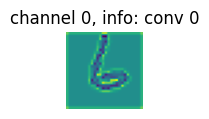

ic| mp0.shape: torch.Size([8, 32, 14, 14])


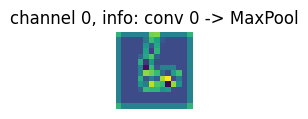

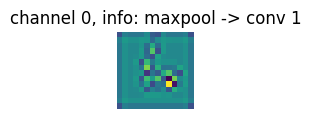

ic| mp1.shape: torch.Size([8, 64, 7, 7])


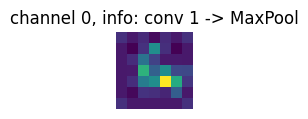

ic| u0.shape: torch.Size([8, 64, 28, 28])


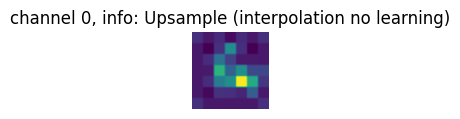

ic| ct0.shape: torch.Size([8, 32, 11, 11])


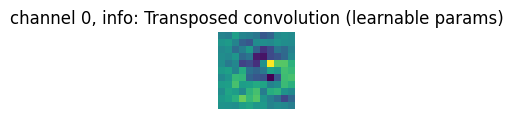

In [9]:
# try with edge detector
laplacian_weight = torch.tensor(
    [[[0, 1, 0], [1, -4, 1], [0, 1, 0]]], dtype=torch.float32
).to(device)


in_channels = 1
out_channels = 1
ic(x.shape)

cnv0 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1, bias=False).to(device)
cnv0.weight = nn.Parameter(laplacian_weight.repeat(32, 1, 1, 1))
c0 = cnv0(x)
ic(c0.shape)
show_channel(c0[0], channel_nb=0, info="conv 0")
max_pool = nn.MaxPool2d(2).to(device)
mp0 = max_pool(c0)
ic(mp0.shape)
show_channel(mp0[0], channel_nb=0, info="conv 0 -> MaxPool")


cnv1 = nn.Conv2d(32, 64, kernel_size=5, padding=1).to(device)
cnv1.weight = nn.Parameter(laplacian_weight.repeat(64, 32, 1, 1))
c1 = cnv1(mp0)
show_channel(c1[0], channel_nb=0, info="maxpool -> conv 1")

mp1 = max_pool(c1)
ic(mp1.shape)
show_channel(mp1[0], channel_nb=0, info="conv 1 -> MaxPool")

# Upsample vs Transpose2d for decoding
upscale = nn.Upsample(scale_factor=4).to(device)
u0 = upscale(mp1)
ic(u0.shape)
show_channel(u0[0], channel_nb=0, info="Upsample (interpolation no learning)")

cnv_tr0 = nn.ConvTranspose2d(64, 32, kernel_size=7, padding=1).to(device)
ct0 = cnv_tr0(mp1)
ic(ct0.shape)
show_channel(ct0[0], channel_nb=0, info="Transposed convolution (learnable params)")

ic| t.shape: torch.Size([8]), y.shape: torch.Size([8])
ic| ux.shape: torch.Size([8, 1, 28, 28])
    x.shape: torch.Size([8, 1, 28, 28])
ic| torchvision.utils.make_grid(x.cpu())[0].shape: torch.Size([32, 242])


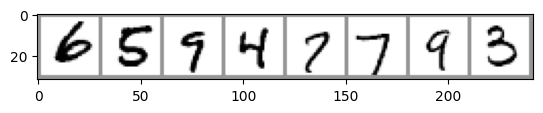

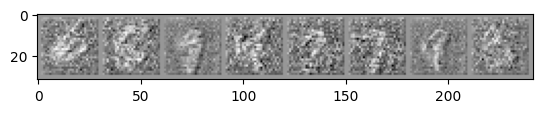

ic| trivial_loss: tensor(-40.4274, device='mps:0', grad_fn=<SumBackward0>)


No unintended batch mixing detected.


In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_timesteps=1000):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim

        # Create a matrix of [max_timesteps, embedding_dim] with positional encodings
        pe = torch.zeros(max_timesteps, embedding_dim)
        position = torch.arange(0, max_timesteps, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2).float()
            * (-math.log(10000.0) / embedding_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        self.register_buffer("pe", pe)

    def forward(self, t):
        """
        Args:
            t: Tensor of shape (batch_size,) containing timesteps.
        Returns:
            Tensor of shape (batch_size, embedding_dim).
        """
        return self.pe[t]


class SimpleDiffusionModel(nn.Module):
    def __init__(self, ctx_nb_feats=10, embedding_dim=128, timesteps: int = 1000):
        super(SimpleDiffusionModel, self).__init__()
        self.ctx_nb_feats = ctx_nb_feats
        self.embedding_dim = embedding_dim

        # Embedding for digit labels
        self.label_embedding = nn.Embedding(ctx_nb_feats, embedding_dim)

        # Positional encoding for timesteps
        self.time_embedding = PositionalEncoding(embedding_dim)
        # self.time_embedding = nn.Embedding(timesteps, embedding_dim)

        # Fully connected layer to project combined embeddings
        self.fc1 = nn.Linear(embedding_dim, 16 * 28 * 28)

        # U-Net-like architecture with skip connections
        self.encoder1 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.encoder2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        # self.encoder3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.decoder1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.decoder1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.decoder2 = nn.ConvTranspose2d(64, 16, kernel_size=3, padding=1)

        self.final_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x, t, c):
        # Embed labels
        label_emb = self.label_embedding(c)  # (batch_size, embedding_dim)

        # Embed timesteps
        time_emb = self.time_embedding(t)  # (batch_size, embedding_dim)

        # Combine label and time embeddings
        combined_emb = label_emb + time_emb  # (batch_size, embedding_dim)

        # Project combined embeddings to match image dimensions
        emb_proj = self.fc1(combined_emb)  # (128 -> 16*28*28)
        emb_proj = emb_proj.view(-1, 16, 28, 28)  # (batch_size, 16, 28, 28)

        # Concatenate embeddings with the input image
        # x = torch.cat([x, emb_proj], dim=1)  # (batch_size, 1+64, 28, 28)

        # Encoder
        # ic(x.shape, emb_proj.shape, "brefore x + emb_proj")
        x = x + emb_proj
        # ic(x.shape, "after x + emb_proj")
        x = F.relu(self.bn1(self.encoder1(x)))
        # NB: pooling prevent the model from working
        skip1 = x  # For potential skip connections

        x = F.relu(self.bn2(self.encoder2(x)))
        skip2 = x  # For potential skip connections

        # skip3 = x
        # x = F.relu(self.encoder3(x))

        # Decoder
        x = F.relu(self.decoder1(x + skip2))
        x = F.relu(self.decoder2(x + skip1))
        # x = F.relu(self.decoder3(x + skip1))

        # Final output
        x = self.final_conv(x)  # No activation
        return x  # Predicted noise


train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
model = SimpleDiffusionModel(ctx_nb_feats=9).to(device)
# x = torch.rand(8, 1, 28, 28)
t = torch.zeros(x.shape[0]).long().to(device)
# oh_y = oh_y.to(device)
x = x.to(device)
y = y.long().to(device)
ic(t.shape, y.shape)
ux = model(x, t, y)
ic(ux.shape, x.shape)
ic(torchvision.utils.make_grid(x.cpu())[0].shape)
plt.imshow(torchvision.utils.make_grid(x.cpu())[0], cmap="Greys")
plt.show()
plt.imshow(torchvision.utils.make_grid(ux.cpu())[0], cmap="Greys")
plt.show()

# test non mixing of batch dimension
# often a bad view/transpose operation can mix batch dimension with other dimension.
# https://karpathy.github.io/2019/04/25/recipe/


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# we backpropagate until the inputs
inputs = torch.rand((8, 1, 28, 28), requires_grad=True, device=device)
model.eval()  # to disable batch norm that breaks this check
output = model(inputs, t, y)
i = 2
trivial_loss = output[i].sum()  # Sum the outputs of example i
ic(trivial_loss)
# Backward pass

model.zero_grad()
trivial_loss.backward()


for idx in range(8):
    if idx == i:
        # We expect non-zero gradients for this example
        assert (
            inputs.grad[idx].abs().sum() > 0
        ), f"Gradient should be non-zero for example {i}"
    else:
        # We expect zero gradients for all other examples
        assert (
            inputs.grad[idx].abs().sum() == 0
        ), f"Unexpected gradient for example {idx}"

print("No unintended batch mixing detected.")

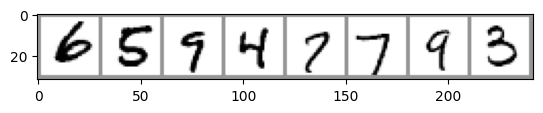

In [11]:
# image show for tensorboard
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


matplotlib_imshow(torchvision.utils.make_grid(x.cpu()), one_channel=True)

### Train SimpleDifusionModel UNet model (DDPM)

https://github.com/nickd16/Diffusion-Models-from-Scratch

In [12]:
def validate_model(
    model,
    val_dataset,
    scheduler,
    num_time_steps: int = 1000,
    batch_size: int = 256,
    device: torch.device = "cpu",
):
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    model.eval()
    with torch.no_grad():
        criterion = nn.MSELoss(reduction="mean")  # .to(device)
        total_val_loss = 0
        for batch_nb, (x, y) in enumerate(val_dataloader):
            x = x.to(device)
            y = y.long().to(device)

            b = x.size(0)
            t = torch.randint(0, num_time_steps, (b,)).to(device)
            x_noisy, noise = scheduler.add_noise_step(x, t)
            x_noisy = x_noisy

            # we may exhaust the loader and have a smaller batch
            output = model(x_noisy, t, y)
            val_loss = criterion(output, noise)
            total_val_loss += val_loss.item()
        mean_loss = total_val_loss / len(val_dataloader)
        model.train()
        return mean_loss


def get_model_name(model_id: str, use_tiny_dataset: bool) -> str:
    model_name = f"mnist_{'tiny_' if use_tiny_dataset else ''}{model_id}"
    return model_name


def train_model(
    get_new_model,
    train_dataset,
    val_dataset=None,
    scheduler=None,
    device="cpu",
    num_time_steps=1000,
    n_epoch=5,
    batch_size=64,
    lr=1e-4,
    lr_decay_factor=0.95,
    model_id="model",
    model_version="0.1",
    log_interval=50,
    last_epoch=0,
    use_tiny_dataset=False,
):
    if use_tiny_dataset:
        random_indices = torch.randperm(len(train_dataset))[:2]
        train_tiny_dataset = torch.utils.data.Subset(train_dataset, random_indices)
        train_dataloader = DataLoader(train_tiny_dataset, batch_size=5, shuffle=True)
    else:
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )

    model_name = get_model_name(model_id, use_tiny_dataset=use_tiny_dataset)
    if last_epoch > 0 and not use_tiny_dataset:
        model = load_model(
            model_name=model_name, model_version=model_version, iter=last_epoch
        ).to(device)
        from_epoch_nb = last_epoch + 1
    else:
        model = get_new_model().to(device)
        from_epoch_nb = 0

    writer = SummaryWriter(
        f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
    )
    criterion = nn.MSELoss(reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
        optimizer, gamma=lr_decay_factor
    )
    # lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    nb_batches = len(train_dataloader)
    model.train()
    i = 0

    def hook_fn(module, input, output):
        # Normalize the output for visualization
        output = (output - output.min()) / (output.max() - output.min())
        # Add a batch dimension and select the first channel
        img_grid = output[0, 0, :, :].unsqueeze(0).unsqueeze(0)
        img_grid = torchvision.utils.make_grid(img_grid.cpu())
        # Log the image
        if i % log_interval == 0:
            writer.add_image(f"{module}", img_grid, global_step=epoch)

    def register_hooks():
        hooks = []
        hooks.append(model.encoder1.register_forward_hook(hook_fn))
        hooks.append(model.encoder2.register_forward_hook(hook_fn))
        # hooks.append(model.encoder3.register_forward_hook(hook_fn))
        hooks.append(model.decoder1.register_forward_hook(hook_fn))
        hooks.append(model.decoder2.register_forward_hook(hook_fn))
        # hooks.append(model.decoder3.register_forward_hook(hook_fn))
        return hooks

    hooks = register_hooks()

    with tqdm(
        total=(n_epoch + 1 - from_epoch_nb) * nb_batches,
        desc=f"Training update",
        unit="batch",
    ) as pbar:
        for epoch in range(from_epoch_nb, n_epoch + 1):
            total_loss = 0
            for batch_nb, (x, y) in enumerate(train_dataloader):
                x = x.to(device)
                y = y.long().to(device)
                b = x.size(0)
                # timestep starts at 0
                t = torch.randint(0, num_time_steps - 1, (b,)).to(device)
                x_noisy, noise = scheduler.add_noise_step(x, t)
                x_noisy = x_noisy.to(device)

                output = model(x_noisy, t, y)
                optimizer.zero_grad()
                loss = criterion(output, noise)
                total_loss += loss.item()
                loss.backward()
                # add gradient clipping
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                i = (epoch * nb_batches) + batch_nb
                writer.add_scalar("train loss", loss.item(), i)
                writer.add_histogram("pred_noise", output, i)
                writer.add_histogram("real_noise", noise, i)
                if i % log_interval == 0:
                    # ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
                    for name, kernel_weight in model.named_parameters():
                        if kernel_weight.numel() > 0:
                            writer.add_histogram(name, kernel_weight, i)
                        if kernel_weight.grad is not None:
                            g = kernel_weight.grad
                            writer.add_histogram(f"{name}.grad", g, i)
                            g_norm = g.data.norm(2)
                            writer.add_histogram(f"{name}.grad_norm", g_norm, i)
                            # add proportion of gradient compared to weights (karpathy)
                            # ud = (
                            #    lr * g
                            # ).std() / kernel_weight.data.std().log10().item()
                            # writer.add_scalar(f"{name}.grad_std_per_weight", ud, i)

                    # TODO sample a few images and display their internal representation

                    if not use_tiny_dataset:
                        val_loss = validate_model(
                            model=model,
                            val_dataset=val_dataset,
                            scheduler=scheduler,
                            num_time_steps=num_time_steps,
                            batch_size=batch_size,
                            device=device,
                        )
                        writer.add_scalar("val loss", val_loss, i)

                pbar.update(1)
                pbar.set_postfix(
                    {
                        "epoch": epoch,
                        "batch_nb": batch_nb,
                        "train_loss": f"{loss.item():.4f}",
                    }
                )

            lr_scheduler.step()
            if not use_tiny_dataset:
                for hook in hooks:
                    hook.remove()
                save_model(
                    model=model,
                    model_name=model_name,
                    model_version=model_version,
                    iter=epoch,
                )
                hooks = register_hooks()

In [13]:
num_time_steps = 1000
scheduler = DDPMScheduler(num_time_steps=num_time_steps, type="linear", device=device)

batch_size = 512
log_interval = 50

use_tiny_dataset = False
model_id = "SimpleDiffusionModel"
model_version = "0.10"
use_tiny_dataset = False
n_epochs = 20
last_epoch_nb = 10
ic.disable()
# make learning rate smaller
if False:
    torch.manual_seed(42)
    train_model(
        get_new_model=lambda: SimpleDiffusionModel(
            ctx_nb_feats=10, timesteps=num_time_steps
        ).to(device),
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size,
        num_time_steps=num_time_steps,
        lr=1e-4,
        n_epoch=n_epochs,
        log_interval=50,
        last_epoch=last_epoch_nb,
        scheduler=scheduler,
        device=device,
        model_id=model_id,
        model_version=model_version,
        use_tiny_dataset=use_tiny_dataset,
    )

version 0.8 or 0.9 is the best one 

### Remarks
- after 5 epochs there are some results. After it only returns grey value with no noise 
- with this model with a tiny dataset (5 examples) it cannot go lower than 0.45 after 1000 or 5000 epochs. It should overfit to 0 loss
- Enhance the model by adding capacity and by checking it overfit to 0 loss with a very small dataset (like 5 samples)

### Ideas

when training, train with all timesteps. !!!!
should i use batch norm in model.
try different learning rates.


/Users/jkunz/Projects/cop_diffusion/cop_diffusion/utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_path)


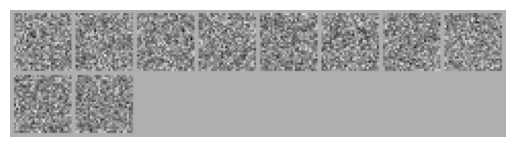

Denoise:  10%|█         | 100/1000 [00:00<00:03, 273.16timestep/s, timestep=900]

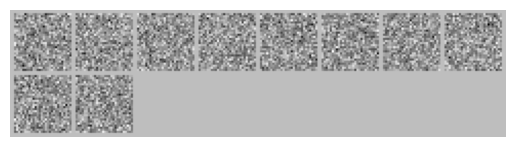

Denoise:  80%|████████  | 800/1000 [00:02<00:00, 400.53timestep/s, timestep=200]

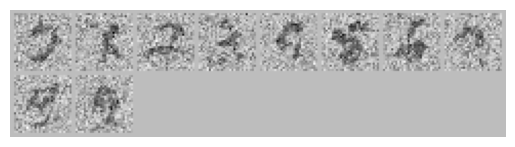

Denoise:  90%|█████████ | 900/1000 [00:02<00:00, 379.56timestep/s, timestep=100]

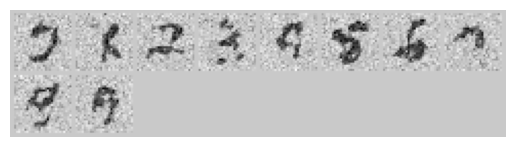

Denoise:  95%|█████████▌| 950/1000 [00:02<00:00, 369.15timestep/s, timestep=50] 

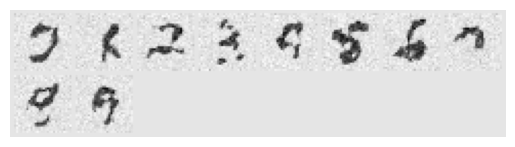

Denoise:  98%|█████████▊| 980/1000 [00:02<00:00, 332.62timestep/s, timestep=20]

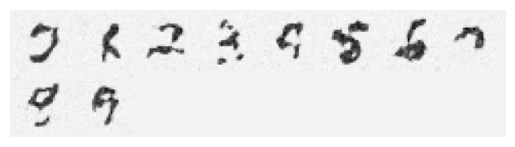

Denoise:  99%|█████████▉| 990/1000 [00:02<00:00, 281.21timestep/s, timestep=10]

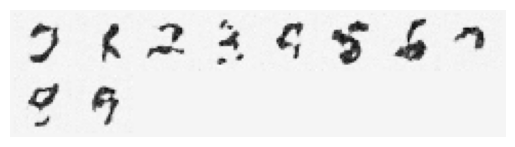

Denoise: 100%|█████████▉| 996/1000 [00:02<00:00, 281.21timestep/s, timestep=4] 

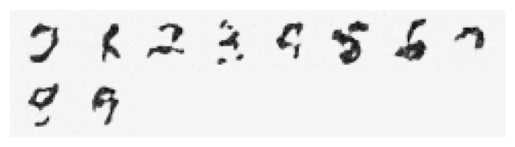

Denoise: 100%|█████████▉| 997/1000 [00:03<00:00, 281.21timestep/s, timestep=3]

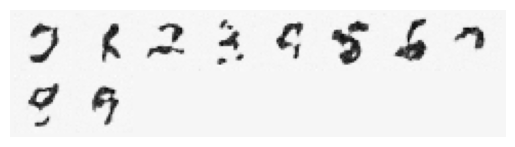

Denoise: 100%|█████████▉| 998/1000 [00:03<00:00, 281.21timestep/s, timestep=2]

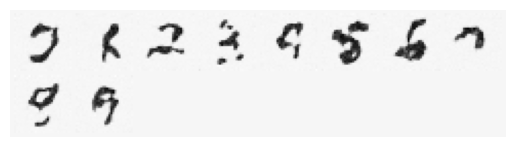

Denoise: 100%|█████████▉| 999/1000 [00:03<00:00, 325.36timestep/s, timestep=1]


In [14]:
# torch.manual_seed(42)
# n_sample = 5
h, w = 28, 28


def show_images(imgs_tensor):
    imgs_tensor = (imgs_tensor * 0.5) + 0.5  # Assuming normalization was to [-1, 1]
    grid = torchvision.utils.make_grid(imgs_tensor.cpu())
    plt.imshow(grid.permute(1, 2, 0)[:, :, 0], cmap="Greys")
    plt.axis("off")
    plt.show()


def generate(
    model: nn.Module,
    scheduler: nn.Module,
    numbers_to_gen: list[int] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    show_timesteps: list[int] = [900, 800, 700, 500, 100, 10, 5, 4, 3, 2, 1],
):
    model.eval()
    with torch.no_grad():
        ctx = torch.tensor(numbers_to_gen).to(device)
        n_sample = ctx.size(0)
        samples = torch.randn(n_sample, 1, h, w).to(device)
        show_images(samples)
        ic(samples.size(), samples.mean(), samples.std())
        with tqdm(
            total=num_time_steps,
            desc=f"Denoise",
            unit="timestep",
        ) as pbar:
            for i in range(num_time_steps - 1, 0, -1):
                t = torch.tensor([i] * n_sample).to(device)
                pred_noise = model(samples, t, ctx)
                samples = scheduler.denoise_step(
                    pred_noise=pred_noise, x_noisy=samples, t=t
                )
                # From t=900, samples.mean() is nan !!!!!
                pbar.update(1)
                pbar.set_postfix(
                    {
                        "timestep": i,
                    }
                )

                if i in show_timesteps:  # or i >995:
                    # show_images(pred_noise)
                    ic(pred_noise.mean(), pred_noise.std())
                    ic(samples.mean(), samples.std())
                    show_images(samples)


if not use_tiny_dataset:
    model_name = get_model_name(model_id, use_tiny_dataset=False)
    model = load_model(
        model_name=model_name, model_version=model_version, iter=n_epochs
    ).to(device)
    generate(
        model,
        numbers_to_gen=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        scheduler=scheduler,
        show_timesteps=[900, 200, 100, 50, 20, 10, 4, 3, 2, 0],
    )

### Complex unet

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))

module:Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


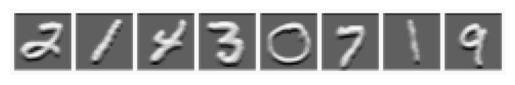

module:BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


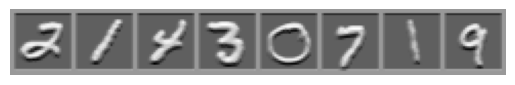

module:ReLU(inplace=True) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


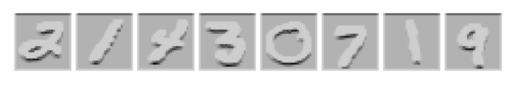

module:Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


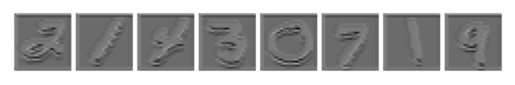

module:BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


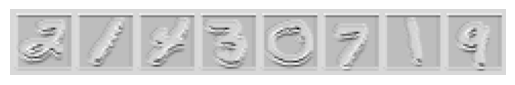

module:ReLU(inplace=True) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


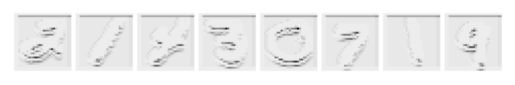

In [39]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


def hook_fn(module, input, output):
    print(f"module:{module} , input: {input[0].shape}, output:{output.shape} ")
    # print(f"min:{output.min()}, mean: {output.mean()}, std: {output.std()}")
    show_images(output)


# Register hooks for each layer in nn.Sequential
model = DoubleConv(1, 1)
for layer in model.conv:
    layer.register_forward_hook(hook_fn)

imgs = model(x)
# show_images(imgs)

In [40]:
class ResidualDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout: float = 0.5):
        super(ResidualDoubleConv, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        return self.dropout(self.double_conv(x) + self.residual_conv(x))

module:Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1)) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


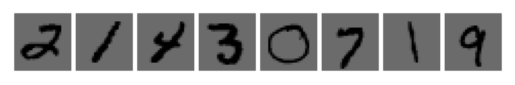

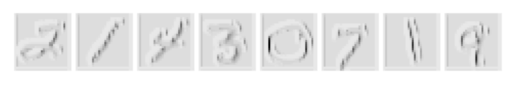

In [41]:
model = ResidualDoubleConv(1, 1, dropout=0.1)
model.residual_conv.register_forward_hook(hook_fn)

imgs = model(x)
show_images(imgs)

module:Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1)) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


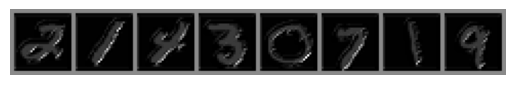

module:Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1)) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


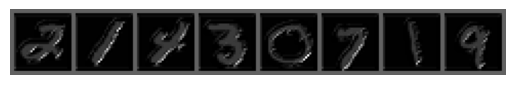

>> Softmax(dim=-1):
output torch.Size([8, 784, 784])


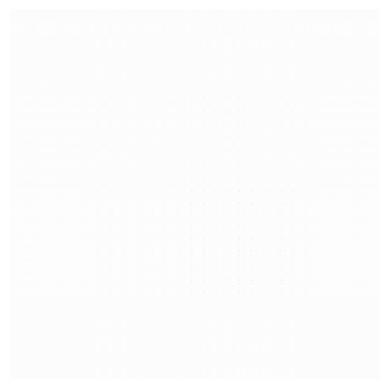

module:Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1)) , input: torch.Size([8, 1, 28, 28]), output:torch.Size([8, 1, 28, 28]) 


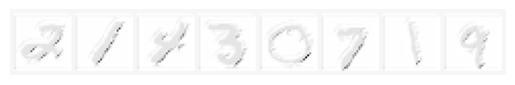

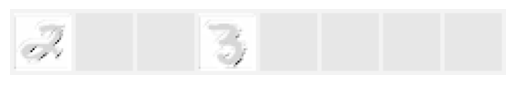

In [43]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, in_channel_divider: int = 8):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(
            in_channels, in_channels // in_channel_divider, kernel_size=1
        )
        self.key = nn.Conv2d(
            in_channels, in_channels // in_channel_divider, kernel_size=1
        )
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.dropout = nn.Dropout2d(0.5)
        self.attention_sftmx = nn.Softmax(dim=-1)  # to be able to access it with a hook

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = (
            self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        )  # batch, w*h,C
        ic(query.shape)
        key = self.key(x).view(batch_size, -1, width * height)
        # like matmul but only for 3d tensor where first dim is batch size
        # attention_bmm = torch.bmm(query, key)
        raw_attention = torch.matmul(query, key)
        # assert torch.equal(attention, attention_bmm)
        # self.attention = F.softmax(attention, dim=-1)
        attn = self.attention_sftmx(raw_attention)
        value = self.value(x).view(batch_size, -1, width * height)
        # out_bmm = torch.bmm(value, self.attention.permute(0, 2, 1))
        out = torch.matmul(value, attn.permute(0, 2, 1))
        # assert torch.equal(out, out_bmm)

        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return self.dropout(out)


def atn_hook_fn(module, input, output):
    """Hook to view attention"""
    print(f">> {module}:")
    print("output", output.shape)
    show_images(output[0])


# in_chann
rc = ResidualDoubleConv(1, 1, dropout=0.0)
rcx = rc(x)
sa = SelfAttention(1, in_channel_divider=1)
sa.query.register_forward_hook(hook_fn)
sa.key.register_forward_hook(hook_fn)
sa.attention_sftmx.register_forward_hook(atn_hook_fn)
sa.value.register_forward_hook(hook_fn)
output = sa(rcx)
show_images(output)

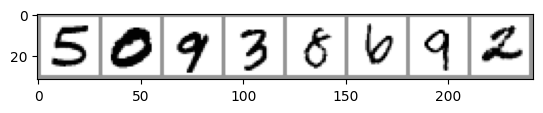

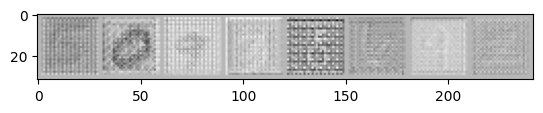

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, embedding_dim=10):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Learnable embeddings
        self.time_embedding = nn.Embedding(
            1000, embedding_dim
        )  # Assuming 1000 different timesteps
        self.class_embedding = nn.Embedding(num_classes, num_classes)

        # Encoder
        self.down1 = ResidualDoubleConv(in_channels + embedding_dim + num_classes, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.attn1 = SelfAttention(64)
        self.down2 = ResidualDoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.attn2 = SelfAttention(128)

        # Bottleneck
        self.bottleneck = ResidualDoubleConv(128, 256)
        self.attn_bottleneck = SelfAttention(256)

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = ResidualDoubleConv(256, 128)
        self.attn3 = SelfAttention(128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = ResidualDoubleConv(128, 64)
        self.attn4 = SelfAttention(64)

        # Final Convolution
        self.final_conv = nn.Conv2d(64, in_channels, kernel_size=1)

    def forward(self, x, t, y):
        b, c, w, h = x.size()
        # Time embedding
        t_emb = self.time_embedding(t).view(t.size(0), self.embedding_dim, 1, 1)
        t_emb = t_emb.expand(-1, -1, w, h)

        # Class embedding
        y_emb = self.class_embedding(y).view(y.size(0), self.num_classes, 1, 1)
        y_emb = y_emb.expand(-1, -1, w, h)

        # Concatenate input, time embedding, and class embedding
        x = torch.cat([x, t_emb, y_emb], dim=1)

        # Encoder
        x1 = self.down1(x)
        x1 = self.attn1(x1)
        x = self.pool1(x1)
        x2 = self.down2(x)
        x2 = self.attn2(x2)
        x = self.pool2(x2)

        # Bottleneck
        x = self.bottleneck(x)
        x = self.attn_bottleneck(x)

        # Decoder
        x = self.up1(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv1(x)
        x = self.attn3(x)
        x = self.up2(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv2(x)
        x = self.attn4(x)

        # Final Convolution
        x = self.final_conv(x)
        return x


# Example usage
model = UNet(in_channels=1, num_classes=10).to(device)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
t = torch.zeros(x.shape[0]).long().to(device)
y = y.long().to(device)
x = x.to(device)

ic(f"Shape of x: {x.shape}, t: {t.shape}, y: {y.shape}")

# Forward pass through the model
ux = model(x, t, y)
ic(ux.shape, x.shape)
ic(torchvision.utils.make_grid(x.cpu())[0].shape)
plt.imshow(torchvision.utils.make_grid(x.cpu())[0], cmap="Greys")
plt.show()
plt.imshow(torchvision.utils.make_grid(ux.cpu())[0], cmap="Greys")
plt.show()

In [ ]:
# check

In [ ]:
model_id = "UNet"
use_tiny_dataset = False
n_epochs = 5

last_epoch_nb = 0
model_version = "0.1"
if True:
    train_model(
        get_new_model=lambda: UNet(in_channels=1, num_classes=10).to(device),
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        n_epoch=5,
        last_epoch=last_epoch_nb,
        num_time_steps=num_time_steps,
        scheduler=scheduler,
        device=device,
        model_id=model_id,
        batch_size=256,
    )

In [ ]:
model_name = get_model_name(model_id, use_tiny_dataset=use_tiny_dataset)
model = load_model(
    model_name=model_name, model_version=model_version, iter=last_epoch_nb
).to(device)

generate(model, numbers_to_gen=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], scheduler=scheduler)